# Métodos Basados en Modelos y Otros Algoritmos - RESUELTOS



---
Este notebook contiene ejercicios prácticos para consolidar los conceptos del Módulo 5.


## Configuración Inicial

In [ ]:
# Importar bibliotecas necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import warnings
warnings.filterwarnings('ignore')

# Scikit-learn
from sklearn.mixture import GaussianMixture
from sklearn.cluster import (
    SpectralClustering, MeanShift, AffinityPropagation, Birch, KMeans
)
from sklearn.cluster import estimate_bandwidth
from sklearn.datasets import make_blobs, make_moons, make_circles
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score, silhouette_score

# Configuración
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 5)
plt.rcParams['font.size'] = 11

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("Entorno configurado correctamente.")

Entorno configurado correctamente.


---

## Ejercicio 1: Tipos de Covarianza en GMM

### Objetivo
Comprender cómo los diferentes tipos de covarianza afectan la capacidad de GMM para modelar clusters de distintas formas.

### Contexto
Se proporciona un dataset con clusters elípticos. Debe ajustar GMM con diferentes tipos de covarianza y comparar los resultados.

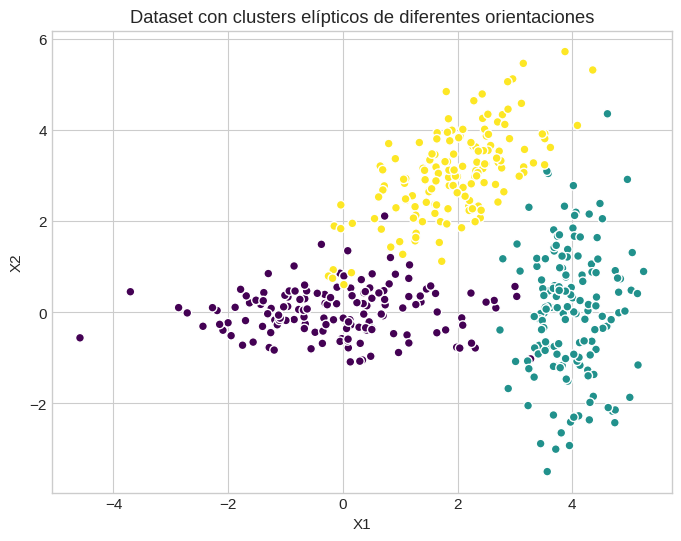

In [ ]:
# Generar dataset con clusters elípticos
np.random.seed(RANDOM_STATE)

# Cluster 1: elipse horizontal
n1 = 150
cluster1 = np.random.multivariate_normal([0, 0], [[2.0, 0], [0, 0.3]], n1)

# Cluster 2: elipse vertical
n2 = 150
cluster2 = np.random.multivariate_normal([4, 0], [[0.3, 0], [0, 2.0]], n2)

# Cluster 3: elipse diagonal
n3 = 150
theta = np.pi / 4
rot = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
cov3 = rot @ np.array([[1.5, 0], [0, 0.3]]) @ rot.T
cluster3 = np.random.multivariate_normal([2, 3], cov3, n3)

X_ej1 = np.vstack([cluster1, cluster2, cluster3])
y_ej1 = np.array([0]*n1 + [1]*n2 + [2]*n3)

# Visualizar datos
plt.figure(figsize=(8, 6))
plt.scatter(X_ej1[:, 0], X_ej1[:, 1], c=y_ej1, cmap='viridis', edgecolors='w', s=40)
plt.title('Dataset con clusters elípticos de diferentes orientaciones')
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

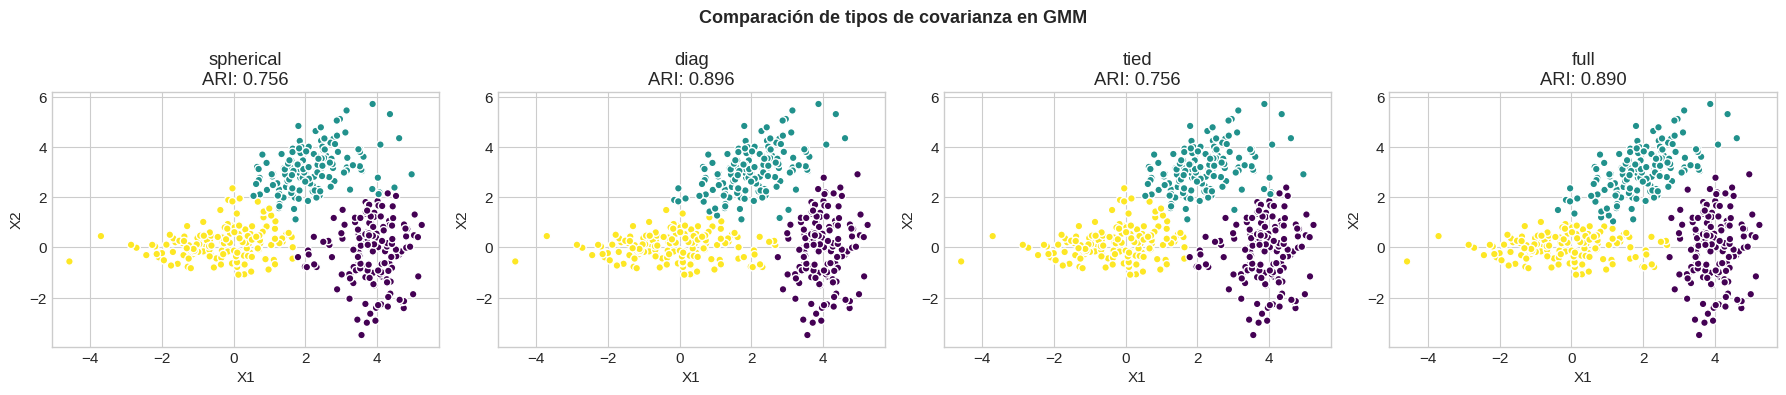


Resultados:
----------------------------------------
Tipo         ARI        BIC            
----------------------------------------
spherical    0.7557     3395.1         
diag         0.8964     3282.4         
tied         0.7557     3386.6         
full         0.8901     3243.3         


In [ ]:
# =============================================================================
# EJERCICIO 1: Completar el código
# =============================================================================

# Lista de tipos de covarianza a evaluar
tipos_covarianza = ['spherical', 'diag', 'tied', 'full']

# Almacenar resultados
resultados_ej1 = []

fig, axes = plt.subplots(1, 4, figsize=(18, 4))

for ax, cov_type in zip(axes, tipos_covarianza):
    # TODO: Crear un modelo GMM con:
    #   - n_components=3
    #   - covariance_type=cov_type
    #   - random_state=RANDOM_STATE
    gmm = GaussianMixture(n_components=3, covariance_type=cov_type,
                          random_state=RANDOM_STATE)

    # TODO: Ajustar el modelo y obtener las etiquetas predichas
    labels = gmm.fit_predict(X_ej1)  # Completar

    # TODO: Calcular el ARI comparando con y_ej1
    ari = adjusted_rand_score(y_ej1, labels)  # Completar

    # TODO: Obtener el BIC del modelo
    bic = gmm.bic(X_ej1)  # Completar

    # Guardar resultados
    resultados_ej1.append({
        'tipo': cov_type,
        'ari': ari,
        'bic': bic
    })

    # Visualizar
    ax.scatter(X_ej1[:, 0], X_ej1[:, 1], c=labels, cmap='viridis',
               edgecolors='w', s=30)
    ax.set_title(f'{cov_type}\nARI: {ari:.3f}')
    ax.set_xlabel('X1')
    ax.set_ylabel('X2')

plt.suptitle('Comparación de tipos de covarianza en GMM', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

# Mostrar tabla de resultados
print("\nResultados:")
print("-" * 40)
print(f"{'Tipo':<12} {'ARI':<10} {'BIC':<15}")
print("-" * 40)
for r in resultados_ej1:
    print(f"{r['tipo']:<12} {r['ari']:<10.4f} {r['bic']:<15.1f}")

### Preguntas de reflexión - Ejercicio 1

1. ¿Por qué el tipo 'spherical' obtiene peores resultados en este dataset?

***Spherical** asume clusters circulares, pero los datos tienen clusters elípticos con diferentes orientaciones.*

2. ¿Qué tipo de covarianza tiene el menor BIC? ¿Coincide con el mejor ARI?

*Generalmente **full** tiene el menor BIC y mejor ARI porque puede modelar elipses arbitrarias*

3. ¿En qué situaciones sería preferible usar 'diag' en lugar de 'full'?

***Diag** es preferible cuando hay menos datos (evita sobreajuste) o cuando las variables son independientes.*

---

## Ejercicio 2: Selección del Número de Componentes

### Objetivo
Aplicar BIC y AIC para determinar el número óptimo de componentes en un GMM.

### Contexto
Se proporciona un dataset donde el número real de clusters no es evidente. Debe implementar la selección de K mediante criterios de información.

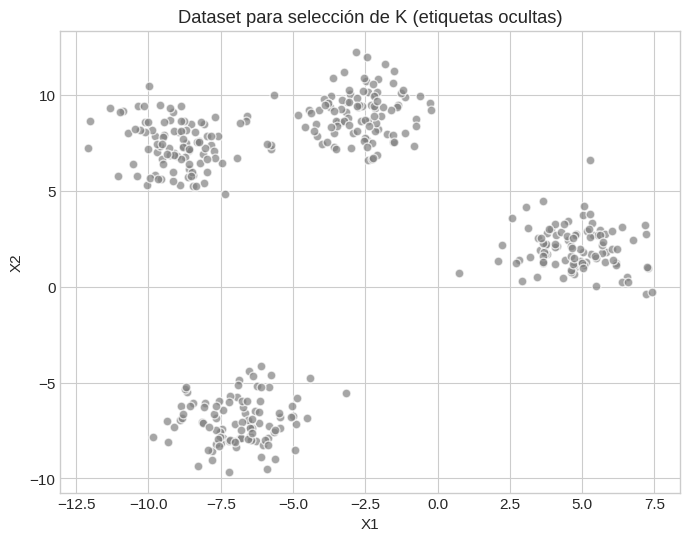

In [ ]:
# Generar dataset con número de clusters oculto
np.random.seed(RANDOM_STATE)

X_ej2, y_ej2 = make_blobs(n_samples=400, centers=4, cluster_std=1.2,
                          random_state=RANDOM_STATE)

# Visualizar sin etiquetas
plt.figure(figsize=(8, 6))
plt.scatter(X_ej2[:, 0], X_ej2[:, 1], c='gray', edgecolors='w', s=40, alpha=0.7)
plt.title('Dataset para selección de K (etiquetas ocultas)')
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

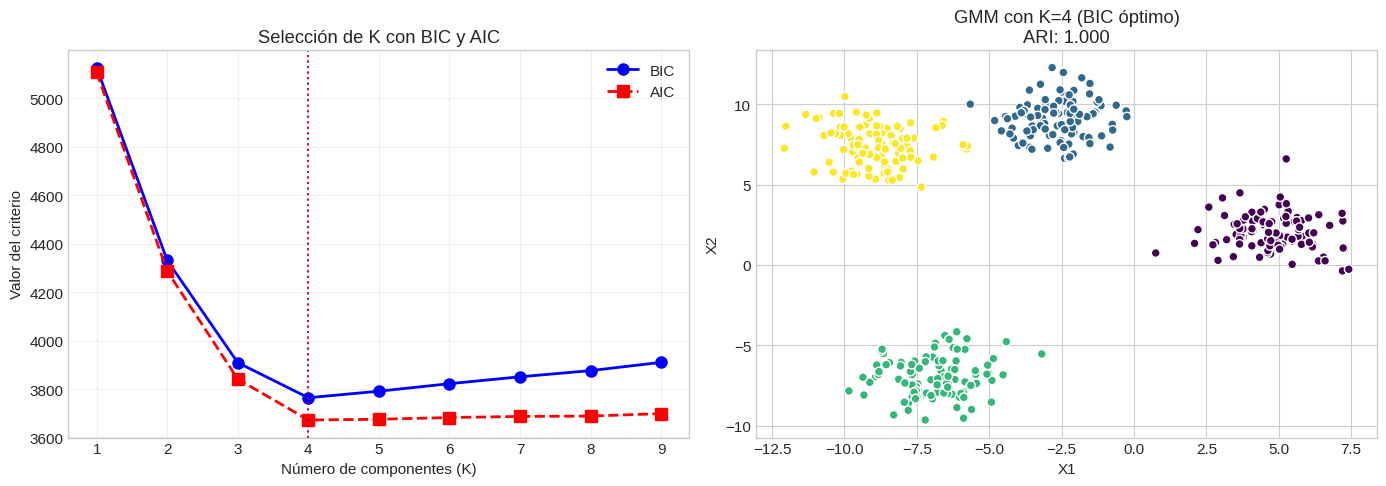


K óptimo según BIC: 4
K óptimo según AIC: 4
K real: 4


In [ ]:
# =============================================================================
# EJERCICIO 2: Completar el código
# =============================================================================

# Rango de componentes a evaluar
rango_k = range(1, 10)

# Listas para almacenar BIC y AIC
valores_bic = []
valores_aic = []

for k in rango_k:
    # TODO: Crear y ajustar un GMM con k componentes
    gmm = GaussianMixture(n_components=k, random_state=RANDOM_STATE)
    gmm.fit(X_ej2)

    # TODO: Calcular y almacenar BIC
    bic = gmm.bic(X_ej2)  # Completar
    valores_bic.append(bic)

    # TODO: Calcular y almacenar AIC
    aic = gmm.aic(X_ej2)  # Completar
    valores_aic.append(aic)

# TODO: Encontrar el K óptimo según BIC (el que minimiza BIC)
k_optimo_bic = list(rango_k)[np.argmin(valores_bic)]  # Completar

# TODO: Encontrar el K óptimo según AIC
k_optimo_aic = list(rango_k)[np.argmin(valores_aic)]  # Completar

# Visualización
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico BIC/AIC
ax = axes[0]
ax.plot(list(rango_k), valores_bic, 'b-o', linewidth=2, markersize=8, label='BIC')
ax.plot(list(rango_k), valores_aic, 'r--s', linewidth=2, markersize=8, label='AIC')
ax.axvline(x=k_optimo_bic, color='blue', linestyle=':', alpha=0.7)
ax.axvline(x=k_optimo_aic, color='red', linestyle=':', alpha=0.7)
ax.set_xlabel('Número de componentes (K)')
ax.set_ylabel('Valor del criterio')
ax.set_title('Selección de K con BIC y AIC')
ax.legend()
ax.grid(True, alpha=0.3)

# Clustering con K óptimo
ax = axes[1]
gmm_optimo = GaussianMixture(n_components=k_optimo_bic, random_state=RANDOM_STATE)
labels_optimo = gmm_optimo.fit_predict(X_ej2)
ari_optimo = adjusted_rand_score(y_ej2, labels_optimo)
ax.scatter(X_ej2[:, 0], X_ej2[:, 1], c=labels_optimo, cmap='viridis',
           edgecolors='w', s=40)
ax.set_title(f'GMM con K={k_optimo_bic} (BIC óptimo)\nARI: {ari_optimo:.3f}')
ax.set_xlabel('X1')
ax.set_ylabel('X2')

plt.tight_layout()
plt.show()

print(f"\nK óptimo según BIC: {k_optimo_bic}")
print(f"K óptimo según AIC: {k_optimo_aic}")
print(f"K real: 4")

### Preguntas de reflexión - Ejercicio 2

1. ¿Por qué BIC tiende a seleccionar modelos más simples que AIC?

*BIC penaliza más los parámetros adicionales (proporcional a log(n)), favoreciendo modelos más simples.*

2. Si BIC y AIC sugieren valores diferentes de K, ¿cuál debería elegir y por qué?

*BIC es preferible para selección de modelo; AIC para predicción. En caso de duda, elegir BIC.*

3. ¿Qué sucedería si el dataset tuviera clusters de tamaños muy diferentes?

*GMM podría requerir más componentes para modelar clusters de tamaños muy diferentes.*

---

## Ejercicio 3: Soft Clustering con GMM

### Objetivo
Explorar las probabilidades de pertenencia (soft clustering) y su utilidad para identificar puntos ambiguos.

### Contexto
Se proporciona un dataset con clusters que se solapan parcialmente. Debe analizar las probabilidades de pertenencia para identificar puntos con alta incertidumbre.

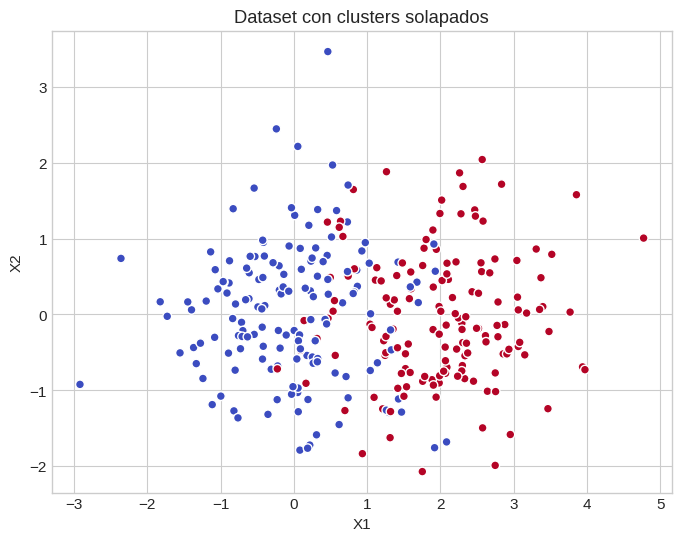

In [ ]:
# Generar dataset con clusters solapados
np.random.seed(RANDOM_STATE)

# Dos clusters cercanos que se solapan
X_ej3, y_ej3 = make_blobs(n_samples=300, centers=[[0, 0], [2, 0]],
                          cluster_std=0.9, random_state=RANDOM_STATE)

plt.figure(figsize=(8, 6))
plt.scatter(X_ej3[:, 0], X_ej3[:, 1], c=y_ej3, cmap='coolwarm',
            edgecolors='w', s=40)
plt.title('Dataset con clusters solapados')
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

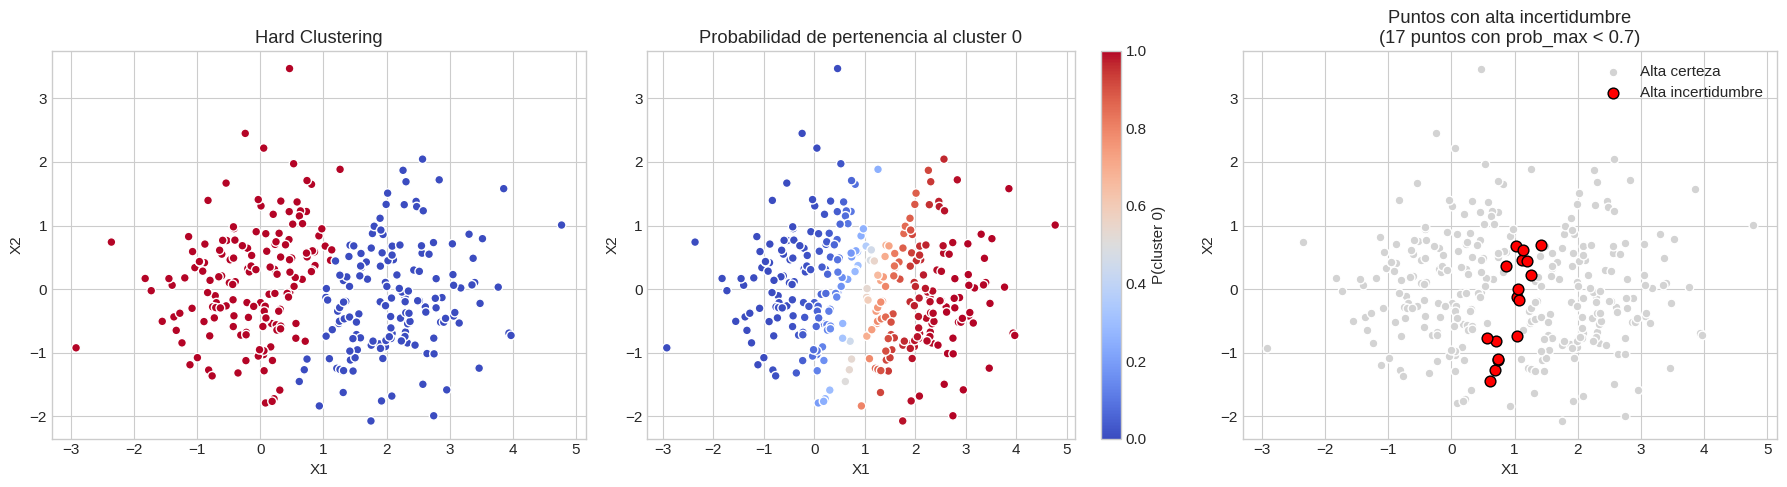


Estadísticas de certeza:
  Probabilidad máxima media: 0.921
  Puntos con alta incertidumbre: 17 (5.7%)


In [ ]:
# =============================================================================
# EJERCICIO 3: Completar el código
# =============================================================================

# Ajustar GMM con 2 componentes
gmm_soft = GaussianMixture(n_components=2, random_state=RANDOM_STATE)
gmm_soft.fit(X_ej3)

# TODO: Obtener las probabilidades de pertenencia usando predict_proba()
probabilidades =  gmm_soft.predict_proba(X_ej3)  # Completar

# TODO: Obtener las etiquetas hard usando predict()
labels_hard = gmm_soft.predict(X_ej3)  # Completar

# TODO: Calcular la probabilidad máxima para cada punto
# (es decir, la probabilidad del cluster más probable)
prob_maxima = probabilidades.max(axis=1)  # Completar

# TODO: Identificar puntos con alta incertidumbre (prob_maxima < 0.7)
mascara_inciertos = prob_maxima < 0.7  # Completar
n_inciertos = mascara_inciertos.sum()

# Visualización
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Hard clustering
ax = axes[0]
ax.scatter(X_ej3[:, 0], X_ej3[:, 1], c=labels_hard, cmap='coolwarm',
           edgecolors='w', s=40)
ax.set_title('Hard Clustering')
ax.set_xlabel('X1')
ax.set_ylabel('X2')

# Probabilidad del cluster 0
ax = axes[1]
scatter = ax.scatter(X_ej3[:, 0], X_ej3[:, 1], c=probabilidades[:, 0],
                     cmap='coolwarm', edgecolors='w', s=40, vmin=0, vmax=1)
plt.colorbar(scatter, ax=ax, label='P(cluster 0)')
ax.set_title('Probabilidad de pertenencia al cluster 0')
ax.set_xlabel('X1')
ax.set_ylabel('X2')

# Puntos inciertos resaltados
ax = axes[2]
ax.scatter(X_ej3[~mascara_inciertos, 0], X_ej3[~mascara_inciertos, 1],
           c='lightgray', edgecolors='w', s=40, label='Alta certeza')
ax.scatter(X_ej3[mascara_inciertos, 0], X_ej3[mascara_inciertos, 1],
           c='red', edgecolors='k', s=60, label='Alta incertidumbre')
ax.set_title(f'Puntos con alta incertidumbre\n({n_inciertos} puntos con prob_max < 0.7)')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.legend()

plt.tight_layout()
plt.show()

print(f"\nEstadísticas de certeza:")
print(f"  Probabilidad máxima media: {prob_maxima.mean():.3f}")
print(f"  Puntos con alta incertidumbre: {n_inciertos} ({100*n_inciertos/len(X_ej3):.1f}%)")

### Preguntas de reflexión - Ejercicio 3

1. ¿Dónde se concentran los puntos con alta incertidumbre? ¿Por qué?

*Los puntos inciertos están en la zona de solapamiento entre clusters, donde ambas gaussianas tienen densidad similar.*

2. ¿Cómo podrían utilizarse las probabilidades de pertenencia en una aplicación real?

*Para identificar clientes ambiguos, priorizar revisión manual, o aplicar diferentes estrategias según certeza.*

3. ¿Qué ventaja tiene el soft clustering sobre el hard clustering para la toma de decisiones?

*El soft clustering permite cuantificar riesgo y tomar decisiones graduales en lugar de binarias.*

---

## Ejercicio 4: Clustering Espectral para Datos No Convexos

### Objetivo
Aplicar clustering espectral a estructuras donde K-Means y GMM fallan, y analizar el efecto de los parámetros.

### Contexto
Se proporciona un dataset con forma de medias lunas entrelazadas. Debe comparar diferentes algoritmos y configuraciones.

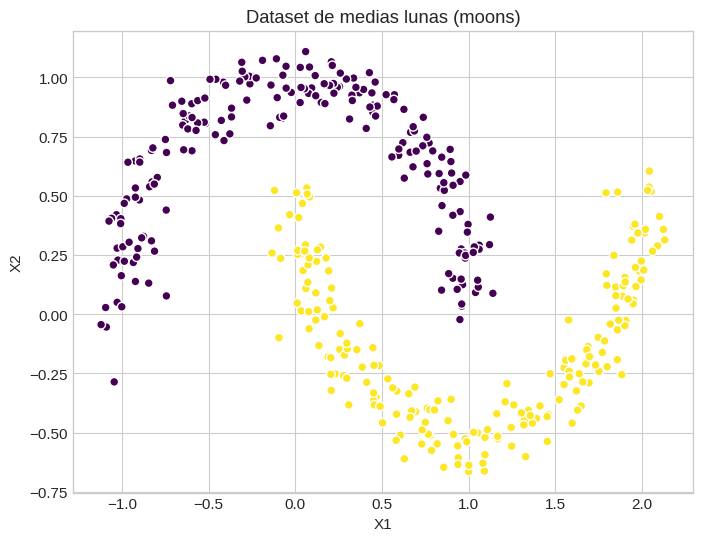

In [ ]:
# Generar dataset de medias lunas
X_ej4, y_ej4 = make_moons(n_samples=400, noise=0.08, random_state=RANDOM_STATE)

plt.figure(figsize=(8, 6))
plt.scatter(X_ej4[:, 0], X_ej4[:, 1], c=y_ej4, cmap='viridis',
            edgecolors='w', s=40)
plt.title('Dataset de medias lunas (moons)')
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

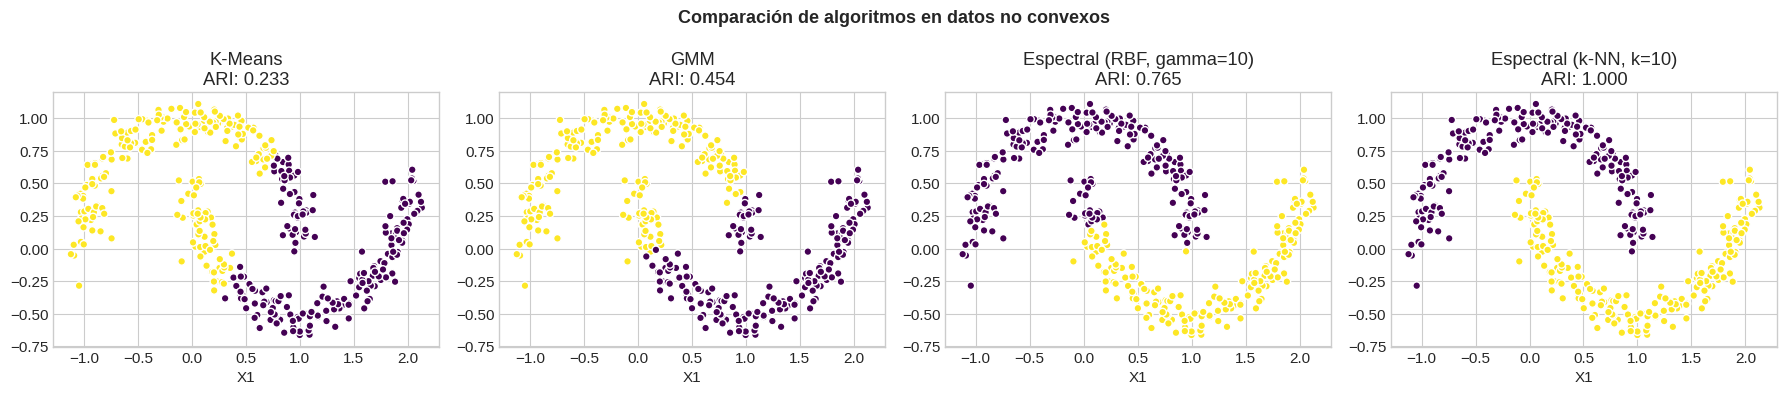


Resumen de ARI:
  K-Means: 0.233
  GMM: 0.454
  Espectral (RBF): 0.765
  Espectral (k-NN): 1.000


In [ ]:
# =============================================================================
# EJERCICIO 4: Completar el código
# =============================================================================

fig, axes = plt.subplots(1, 4, figsize=(18, 4))

# K-Means (baseline)
ax = axes[0]
kmeans = KMeans(n_clusters=2, random_state=RANDOM_STATE, n_init=10)
labels_km = kmeans.fit_predict(X_ej4)
ari_km = adjusted_rand_score(y_ej4, labels_km)
ax.scatter(X_ej4[:, 0], X_ej4[:, 1], c=labels_km, cmap='viridis', edgecolors='w', s=30)
ax.set_title(f'K-Means\nARI: {ari_km:.3f}')
ax.set_xlabel('X1')

# GMM
ax = axes[1]
gmm = GaussianMixture(n_components=2, random_state=RANDOM_STATE)
labels_gmm = gmm.fit_predict(X_ej4)
ari_gmm = adjusted_rand_score(y_ej4, labels_gmm)
ax.scatter(X_ej4[:, 0], X_ej4[:, 1], c=labels_gmm, cmap='viridis', edgecolors='w', s=30)
ax.set_title(f'GMM\nARI: {ari_gmm:.3f}')
ax.set_xlabel('X1')

# TODO: Clustering Espectral con affinity='rbf' y gamma=10
ax = axes[2]
# Completar: SpectralClustering con n_clusters=2, affinity='rbf', gamma=10
spectral_rbf = SpectralClustering(n_clusters=2, affinity='rbf', gamma=10,
                                   random_state=RANDOM_STATE)
labels_rbf = spectral_rbf.fit_predict(X_ej4)  # Completar: fit_predict
ari_rbf = adjusted_rand_score(y_ej4, labels_rbf)
ax.scatter(X_ej4[:, 0], X_ej4[:, 1], c=labels_rbf, cmap='viridis', edgecolors='w', s=30)
ax.set_title(f'Espectral (RBF, gamma=10)\nARI: {ari_rbf:.3f}')
ax.set_xlabel('X1')

# TODO: Clustering Espectral con affinity='nearest_neighbors' y n_neighbors=10
ax = axes[3]
# Completar: SpectralClustering con affinity='nearest_neighbors', n_neighbors=10
spectral_knn = SpectralClustering(n_clusters=2, affinity='nearest_neighbors',
                                   n_neighbors=10, random_state=RANDOM_STATE)
labels_knn = spectral_knn.fit_predict(X_ej4)  # Completar: fit_predict
ari_knn = adjusted_rand_score(y_ej4, labels_knn)
ax.scatter(X_ej4[:, 0], X_ej4[:, 1], c=labels_knn, cmap='viridis', edgecolors='w', s=30)
ax.set_title(f'Espectral (k-NN, k=10)\nARI: {ari_knn:.3f}')
ax.set_xlabel('X1')

plt.suptitle('Comparación de algoritmos en datos no convexos', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\nResumen de ARI:")
print(f"  K-Means: {ari_km:.3f}")
print(f"  GMM: {ari_gmm:.3f}")
print(f"  Espectral (RBF): {ari_rbf:.3f}")
print(f"  Espectral (k-NN): {ari_knn:.3f}")

### Preguntas de reflexión - Ejercicio 4

1. ¿Por qué K-Means y GMM no pueden separar correctamente las medias lunas?

*K-Means y GMM asumen clusters convexos (esféricos/elípticos), no pueden capturar formas curvas.*

2. ¿Qué diferencia hay entre usar affinity='rbf' vs 'nearest_neighbors'?

*RBF usa similitud global basada en distancia; k-NN solo considera vecinos locales (más robusto a variaciones de densidad).*

3. ¿Qué sucedería si gamma fuera muy pequeño (ej. 0.1) en el kernel RBF?

*Con gamma muy bajo, todos los puntos serían similares entre sí, resultando en un solo cluster.*

---

## Ejercicio 5: Algoritmos que No Requieren K

### Objetivo
Aplicar Mean-Shift y Affinity Propagation, que determinan automáticamente el número de clusters.

### Contexto
Se proporciona un dataset donde el número de clusters es desconocido. Debe aplicar ambos algoritmos y analizar sus resultados.

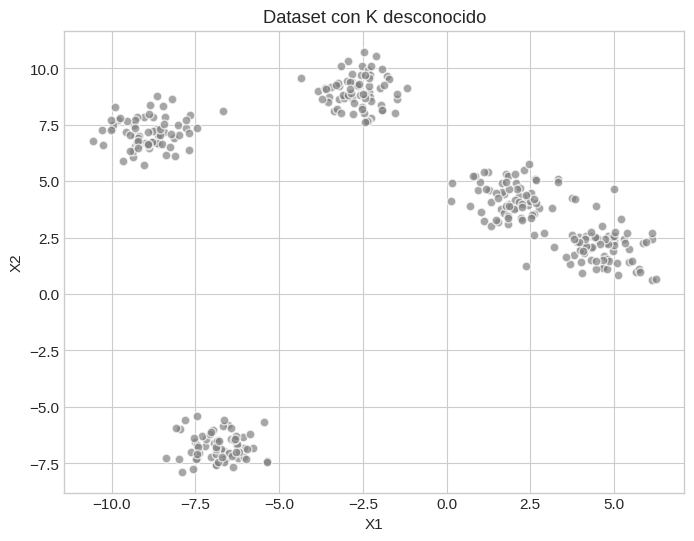

In [ ]:
# Generar dataset con número de clusters desconocido
np.random.seed(RANDOM_STATE)

X_ej5, y_ej5 = make_blobs(n_samples=350, centers=5, cluster_std=0.7,
                          random_state=RANDOM_STATE)

plt.figure(figsize=(8, 6))
plt.scatter(X_ej5[:, 0], X_ej5[:, 1], c='gray', edgecolors='w', s=40, alpha=0.7)
plt.title('Dataset con K desconocido')
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

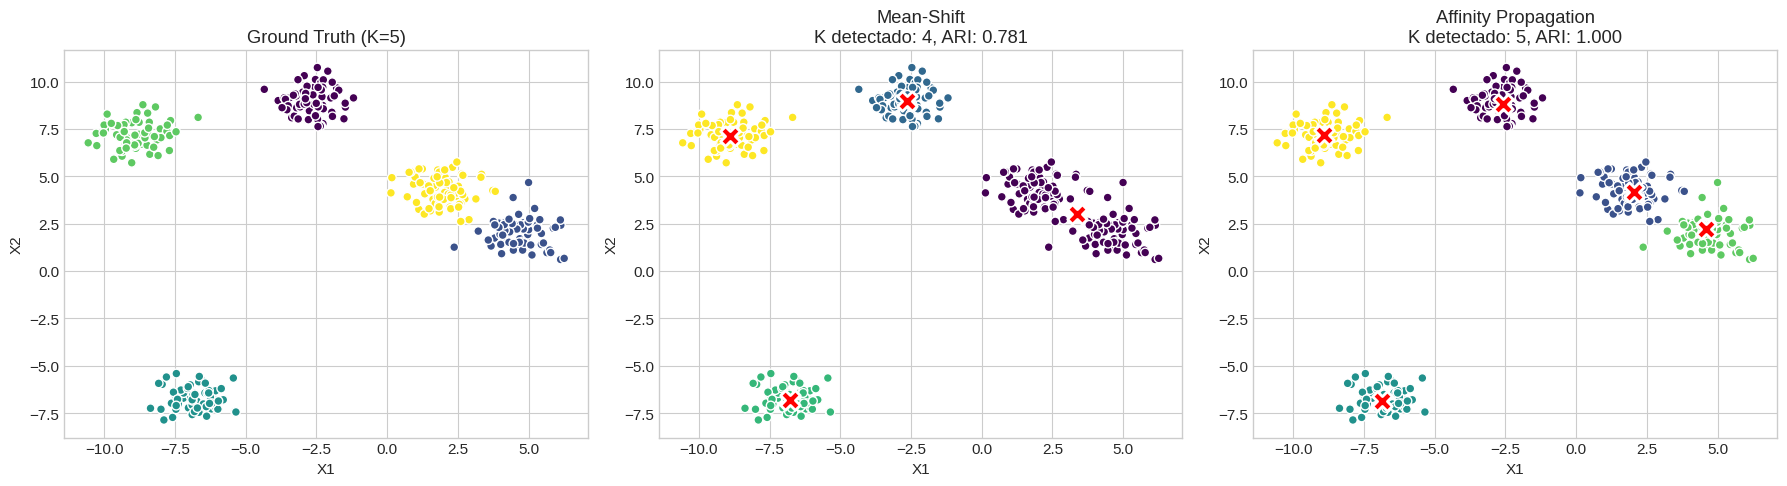


Resultados:
  K real: 5
  Mean-Shift detectó: 4 clusters (bandwidth=2.48)
  Affinity Propagation detectó: 5 clusters


In [ ]:
# =============================================================================
# EJERCICIO 5: Completar el código
# =============================================================================

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Ground truth
ax = axes[0]
ax.scatter(X_ej5[:, 0], X_ej5[:, 1], c=y_ej5, cmap='viridis', edgecolors='w', s=40)
ax.set_title(f'Ground Truth (K=5)')
ax.set_xlabel('X1')
ax.set_ylabel('X2')

# Mean-Shift
ax = axes[1]

# TODO: Estimar el bandwidth usando estimate_bandwidth con quantile=0.2
bandwidth = estimate_bandwidth(X_ej5, quantile=0.2)  # Completar

# TODO: Crear y ajustar MeanShift con el bandwidth estimado
ms =  MeanShift(bandwidth=bandwidth)  # Completar
labels_ms =  ms.fit_predict(X_ej5)  # Completar

k_ms = len(np.unique(labels_ms))
ari_ms = adjusted_rand_score(y_ej5, labels_ms)

ax.scatter(X_ej5[:, 0], X_ej5[:, 1], c=labels_ms, cmap='viridis', edgecolors='w', s=40)
ax.scatter(ms.cluster_centers_[:, 0], ms.cluster_centers_[:, 1],
           c='red', marker='X', s=200, edgecolors='w', linewidths=2)
ax.set_title(f'Mean-Shift\nK detectado: {k_ms}, ARI: {ari_ms:.3f}')
ax.set_xlabel('X1')
ax.set_ylabel('X2')

# Affinity Propagation
ax = axes[2]

# TODO: Crear y ajustar AffinityPropagation con damping=0.9 y preference=-50
ap = AffinityPropagation(damping=0.9, preference=-50, random_state=RANDOM_STATE)  # Completar
labels_ap = ap.fit_predict(X_ej5)  # Completar

k_ap = len(np.unique(labels_ap))
ari_ap = adjusted_rand_score(y_ej5, labels_ap)

# Obtener ejemplares
ejemplares = ap.cluster_centers_indices_

ax.scatter(X_ej5[:, 0], X_ej5[:, 1], c=labels_ap, cmap='viridis', edgecolors='w', s=40)
ax.scatter(X_ej5[ejemplares, 0], X_ej5[ejemplares, 1],
           c='red', marker='X', s=200, edgecolors='w', linewidths=2)
ax.set_title(f'Affinity Propagation\nK detectado: {k_ap}, ARI: {ari_ap:.3f}')
ax.set_xlabel('X1')
ax.set_ylabel('X2')

plt.tight_layout()
plt.show()

print(f"\nResultados:")
print(f"  K real: 5")
print(f"  Mean-Shift detectó: {k_ms} clusters (bandwidth={bandwidth:.2f})")
print(f"  Affinity Propagation detectó: {k_ap} clusters")

### Preguntas de reflexión - Ejercicio 5

1. ¿Qué diferencia hay entre los centroides de Mean-Shift y los ejemplares de Affinity Propagation?

*Los centroides de Mean-Shift son medias ponderadas calculadas y los de Affinity Propagation son puntos reales del dataset*

2. ¿Cómo afectaría cambiar el parámetro `preference` en Affinity Propagation?

*Preference más negativo = menos clusters; más positivo = más clusters.
Comprobar...*

3. ¿En qué escenarios sería preferible cada algoritmo?

*Mean-Shift para datos con densidad variable; Affinity Propagation cuando se necesitan ejemplares reales como prototipos*

---

## Ejercicio 6: Caso Integrador - Segmentación de Clientes

### Objetivo
Aplicar múltiples algoritmos del módulo a un problema de segmentación de clientes y seleccionar el mejor enfoque.

### Contexto
Se dispone de datos de comportamiento de compra de clientes. Debe segmentarlos utilizando GMM, Clustering Espectral y BIRCH, comparando los resultados.

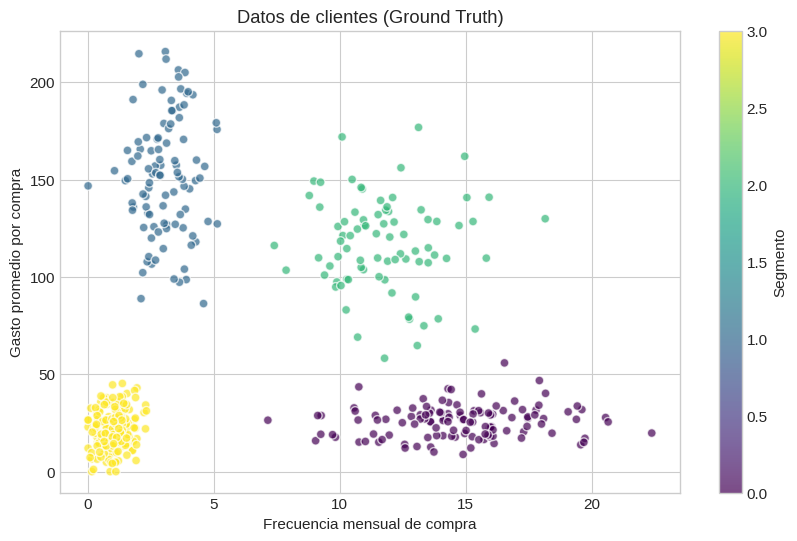

In [ ]:
# Generar datos de clientes simulados
np.random.seed(RANDOM_STATE)

n_clientes = 500

# Segmento 1: Clientes frecuentes de bajo gasto
seg1 = np.column_stack([
    np.random.normal(15, 3, 120),   # frecuencia mensual
    np.random.normal(25, 8, 120)    # gasto promedio
])

# Segmento 2: Clientes ocasionales de alto gasto
seg2 = np.column_stack([
    np.random.normal(3, 1, 100),
    np.random.normal(150, 30, 100)
])

# Segmento 3: Clientes premium (alta frecuencia, alto gasto)
seg3 = np.column_stack([
    np.random.normal(12, 2, 80),
    np.random.normal(120, 25, 80)
])

# Segmento 4: Clientes inactivos
seg4 = np.column_stack([
    np.random.normal(1, 0.5, 200),
    np.random.normal(20, 10, 200)
])

X_clientes = np.vstack([seg1, seg2, seg3, seg4])
X_clientes = np.clip(X_clientes, 0, None)  # No valores negativos
y_clientes = np.array([0]*120 + [1]*100 + [2]*80 + [3]*200)

# Estandarizar
scaler = StandardScaler()
X_clientes_scaled = scaler.fit_transform(X_clientes)

# Visualizar
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_clientes[:, 0], X_clientes[:, 1], c=y_clientes,
                      cmap='viridis', edgecolors='w', s=40, alpha=0.7)
plt.xlabel('Frecuencia mensual de compra')
plt.ylabel('Gasto promedio por compra')
plt.title('Datos de clientes (Ground Truth)')
plt.colorbar(scatter, label='Segmento')
plt.show()

In [ ]:
# =============================================================================
# EJERCICIO 6: Completar el código
# =============================================================================

# Primero, usar BIC para determinar K óptimo con GMM
bics_clientes = []
for k in range(2, 8):
    gmm_temp = GaussianMixture(n_components=k, random_state=RANDOM_STATE)
    gmm_temp.fit(X_clientes_scaled)
    bics_clientes.append(gmm_temp.bic(X_clientes_scaled))

k_optimo = np.argmin(bics_clientes) + 2
print(f"K óptimo según BIC: {k_optimo}")



K óptimo según BIC: 4


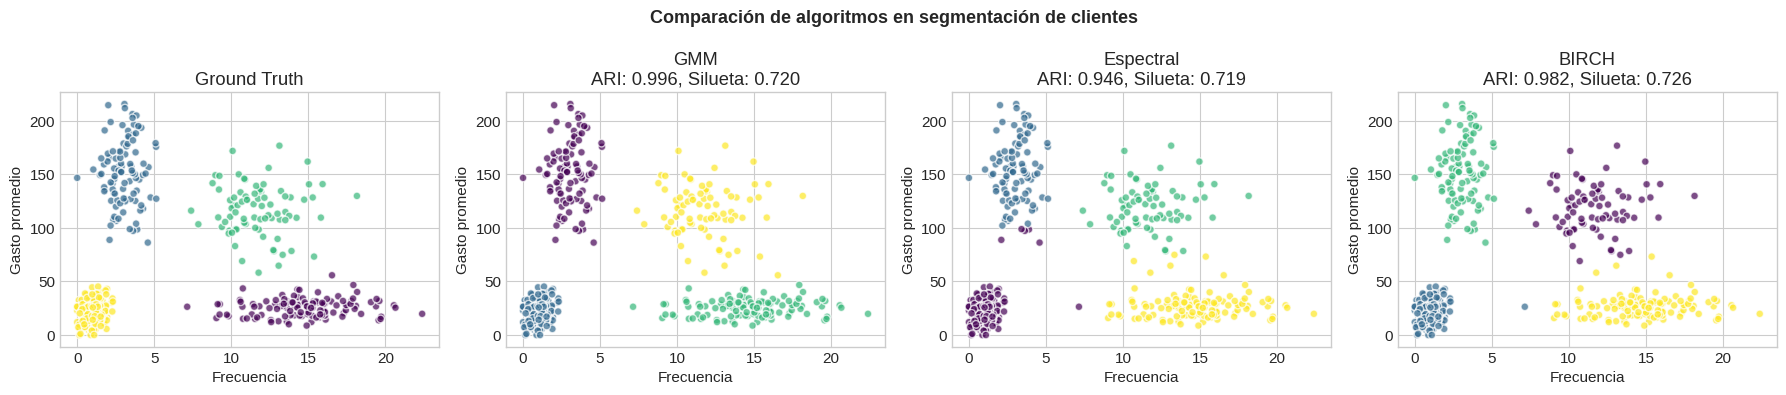


Comparación de algoritmos:
---------------------------------------------
Algoritmo       ARI        Silueta   
---------------------------------------------
GMM             0.9961     0.7198    
Espectral       0.9456     0.7193    
BIRCH           0.9821     0.7257    


In [ ]:
# Comparar algoritmos con K=4
resultados_clientes = []

# TODO: GMM con covariance_type='full'
gmm_clientes = GaussianMixture(n_components=4, covariance_type='full',
                                random_state=RANDOM_STATE)
labels_gmm_c = gmm_clientes.fit_predict(X_clientes_scaled)
ari_gmm_c = adjusted_rand_score(y_clientes, labels_gmm_c)
sil_gmm_c = silhouette_score(X_clientes_scaled, labels_gmm_c)
resultados_clientes.append(('GMM', ari_gmm_c, sil_gmm_c, labels_gmm_c))

# TODO: Clustering Espectral con affinity='rbf'
spec_clientes = SpectralClustering(n_clusters=4, affinity='rbf',
                                    random_state=RANDOM_STATE)
labels_spec_c = spec_clientes.fit_predict(X_clientes_scaled)
ari_spec_c = adjusted_rand_score(y_clientes, labels_spec_c)
sil_spec_c = silhouette_score(X_clientes_scaled, labels_spec_c)
resultados_clientes.append(('Espectral', ari_spec_c, sil_spec_c, labels_spec_c))

# TODO: BIRCH con n_clusters=4 y threshold=0.5
birch_clientes = Birch(n_clusters=4, threshold=0.5)
labels_birch_c = birch_clientes.fit_predict(X_clientes_scaled)
ari_birch_c = adjusted_rand_score(y_clientes, labels_birch_c)
sil_birch_c = silhouette_score(X_clientes_scaled, labels_birch_c)
resultados_clientes.append(('BIRCH', ari_birch_c, sil_birch_c, labels_birch_c))

# Visualización
fig, axes = plt.subplots(1, 4, figsize=(18, 4))

# Ground truth
ax = axes[0]
ax.scatter(X_clientes[:, 0], X_clientes[:, 1], c=y_clientes,
           cmap='viridis', edgecolors='w', s=30, alpha=0.7)
ax.set_title('Ground Truth')
ax.set_xlabel('Frecuencia')
ax.set_ylabel('Gasto promedio')

# Resultados de cada algoritmo
for i, (nombre, ari, sil, labels) in enumerate(resultados_clientes):
    ax = axes[i+1]
    ax.scatter(X_clientes[:, 0], X_clientes[:, 1], c=labels,
               cmap='viridis', edgecolors='w', s=30, alpha=0.7)
    ax.set_title(f'{nombre}\nARI: {ari:.3f}, Silueta: {sil:.3f}')
    ax.set_xlabel('Frecuencia')
    ax.set_ylabel('Gasto promedio')

plt.suptitle('Comparación de algoritmos en segmentación de clientes',
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

# Tabla comparativa
print("\nComparación de algoritmos:")
print("-" * 45)
print(f"{'Algoritmo':<15} {'ARI':<10} {'Silueta':<10}")
print("-" * 45)
for nombre, ari, sil, _ in resultados_clientes:
    print(f"{nombre:<15} {ari:<10.4f} {sil:<10.4f}")

### Preguntas de reflexión - Ejercicio 6

1. ¿Qué algoritmo obtuvo mejores resultados? ¿Por qué cree que fue así?

*GMM suele funcionar bien porque los segmentos de clientes tienden a ser aproximadamente gaussiano y/o elíptico*

2. ¿Qué ventajas tendría GMM sobre BIRCH para este caso de segmentación?

*GMM proporciona probabilidades de pertenencia, útiles para marketing (clientes en límite entre segmentos).*

3. Si el dataset tuviera millones de clientes, ¿qué algoritmo recomendaría?

*BIRCH por su escalabilidad O(n) y bajo uso de memoria*

---
# EOF (End Of File)